# Result

Here are presented the first results of the analyse of Wikipedia RFA. For more detail about our work, method, timeline and objective, see the readme on the github reprository here: https://github.com/epfl-ada/ada-2024-project-supercoolteamname2024/tree/main

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
import os
import csv
from scipy.stats import chi2_contingency
from IPython.display import display  # For rendering in Jupyter Notebook
from IPython.display import HTML


# Read the data from classifications.txt file
file_path = os.path.join('data', 'user_categories_clean.csv')

# Parse the file with careful handling for embedded commas and quotes
rows = []
with open(file_path, 'r') as file:
    reader = csv.reader(file, delimiter=',', quotechar='"', skipinitialspace=True)
    for line in reader:
        rows.append(line)

# Create a DataFrame from parsed data
df = pd.DataFrame(rows[1:], columns=rows[0])  # Use the first row as the header

# Fix incorrect splits for usernames or categories
# Combine values if a row has more columns than expected (e.g., 5)
fixed_rows = []
expected_columns = len(rows[0])  # Expecting 5 columns (username + 4 categories)
for row in rows[1:]:
    if len(row) > expected_columns:
        fixed_row = row[:expected_columns - 1] + [','.join(row[expected_columns - 1:])]
        fixed_rows.append(fixed_row)
    elif len(row) == expected_columns:
        fixed_rows.append(row)

# Create a DataFrame from fixed rows
df = pd.DataFrame(fixed_rows, columns=rows[0])

# Replace non-matching categories with NaN
categories = [
    "Arts", "Academic disciplines", "Business", "Biology", "Communication", "Concepts", "Culture", "Economy", "Education", "Energy",
    "Engineering", "Environment", "Entertainment", "Entities", "Food and drink", "Geography", "Government", "Health", "History",
    "Human behavior", "Humanities", "Information", "Internet", "Knowledge", "Language", "Law", "Life", "Lists", "Literature",
    "Mass media", "Media", "Mathematics", "Military", "Music", "Nature", "People", "Philosophy", "Politics", "Religion", "Science", 
    "Society", "Sports", "Technology", "Time", "Transportation", "Television", "Universe"
]


# Display the updated DataFrame
display(df.head())
for col in df.columns[1:]:  # Exclude the first column (username)
    df[col] = df[col].apply(lambda x: x if x in categories else np.nan)
    
# Build the category_mapping dictionary
category_mapping = {}
for _, row in df.iterrows():
    username = row['username']
    user_categories = row[1:].dropna().tolist()  # Exclude NaN categories
    category_mapping[username] = user_categories


# Count the total number of NaN values in the DataFrame
total_nans = df.isna().sum().sum()

# Print the result
print(f"Total number of NaN values: {total_nans}")

# Count NaN values per column
nans_per_column = df.isna().sum()

# Print the per-column breakdown
print("\nNaN values per column:")
print(nans_per_column)


,username,categ1,categ2,categ3,categ4
0,!---slappdash---!,Entertainment,Music,Sports,Culture
1,%D0%90,Mass media,Lists,Geography,Education
2,'sed',Television,Cartoons,Culture,Humor
3,(.Y.),Music,Lists,Technology,Entertainment
4,(Julien:):,Sports,Politics,Society,History


Total number of NaN values: 4041

NaN values per column:
username       0
categ1       492
categ2       841
categ3      1176
categ4      1532
dtype: int64


# Categories distribution

Top 15 Categories by User Count: ['', 'History', 'Entertainment', 'Culture', 'Geography', 'Society', 'Technology', 'People', 'Politics', 'Sports', 'Education', 'Science', 'Government', 'Religion', 'Lists']


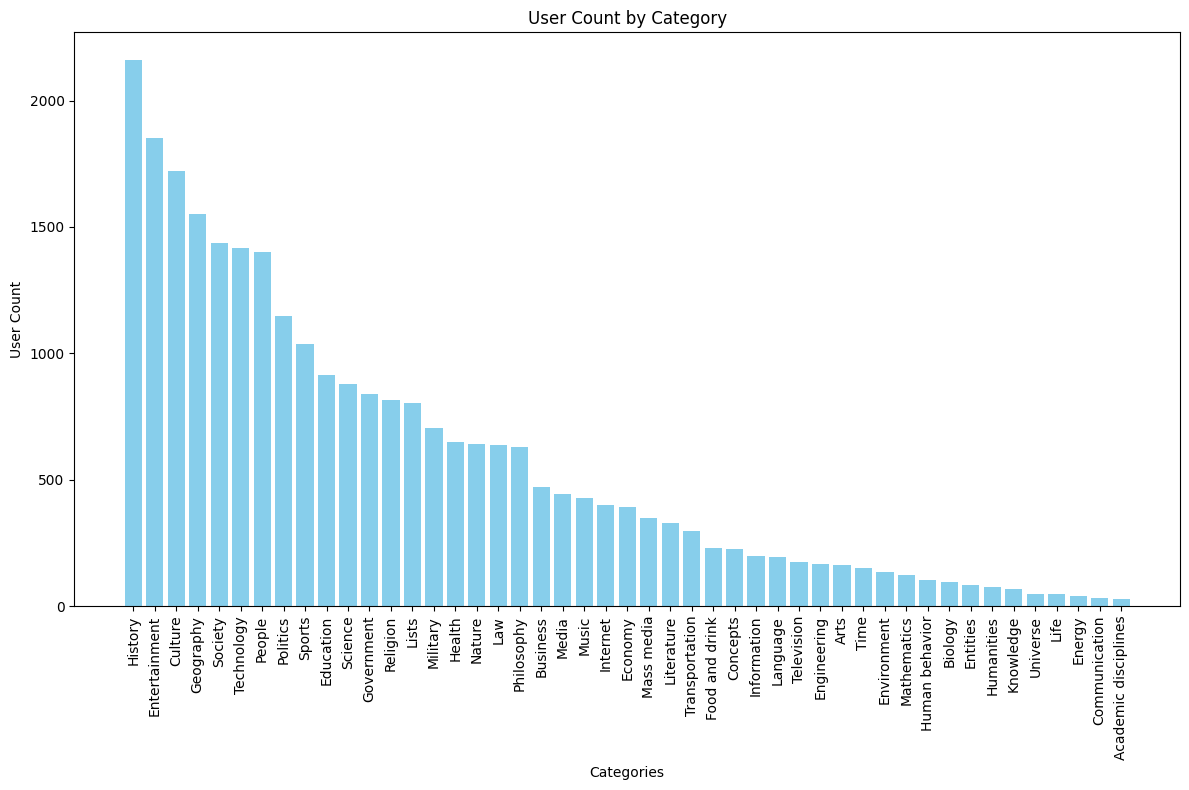

In [72]:
# Flatten all category columns and count occurrences of categories
flattened_categories = df.iloc[:, 1:].fillna('').values.flatten()
category_counts = pd.Series(flattened_categories).value_counts()
# Select the top 15 categories by user count
top_15_categories = category_counts.head(15).index.tolist()
print(f"Top 15 Categories by User Count: {top_15_categories}")


# Create a DataFrame for counts
topic_counts_df = category_counts.reset_index()
topic_counts_df.columns = ['Topic', 'Count']
topic_counts_df = topic_counts_df[topic_counts_df['Topic'].isin(categories)]  # Filter for valid categories

# Plotting the topics with their counts in the order provided
plt.figure(figsize=(12, 8))
plt.bar(topic_counts_df["Topic"], topic_counts_df["Count"], color="skyblue")
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.xlabel("Categories")
plt.ylabel("User Count")
plt.title("User Count by Category")
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()



The bar chart illustrates a diverse distribution of user interests across various categories, with each user potentially belonging to up to 4 different categories. The varying sizes of these categories may be attributed to the breadth of the topics themselves, as some categories, like Technology, may encompass broader subtopics such as Internet. Notably, certain categories have significantly higher user counts, while others are relatively small. To ensure statistical significance in subsequent analyses, we plan to exclude the smallest categories where the sample size may be insufficient for robust conclusions

# Participation rate same/different group

In [73]:
data = {
    "SRC": [],
    "TGT": [],
    "VOT": [],
    "Category_Same": [],
    "SRC_Category": [],
    "TGT_Category": [],
    "DAT": [],  # Add a column for DAT (date)
}

# Initialize the data dictionary to store parsed records
with open('data/wiki-RfA.txt', 'r', encoding='utf-8') as file:
    record = {}
    for line in file:
        line = line.strip()
        
        # Check if line is empty (end of a record)
        if not line:
            # Save the current record if it has data and reset
            if record:
                # Ensure SRC and TGT users are mapped to categories
                src_cat = set(category_mapping.get(record.get("SRC", ""), []))
                tgt_cat = set(category_mapping.get(record.get("TGT", ""), []))
                
                # Skip if either source or target has no categories assigned
                if not src_cat or not tgt_cat:
                    record = {}
                    continue
                
                # Determine if categories match
                record["Category_Same"] = int(bool(src_cat & tgt_cat))  # 1 if any category matches, else 0
                record["SRC_Category"] = list(src_cat & set(top_15_categories))  # Intersection with top categories
                record["TGT_Category"] = list(tgt_cat & set(top_15_categories))  # Intersection with top categories
                
                # Append record to data dictionary
                data["SRC"].append(record.get("SRC", ""))
                data["TGT"].append(record.get("TGT", ""))
                data["VOT"].append(int(record.get("VOT", 0)))
                data["DAT"].append(record.get("DAT", ""))  # Append DAT to data
                data["Category_Same"].append(record["Category_Same"])
                data["SRC_Category"].append(record["SRC_Category"][0] if record["SRC_Category"] else None)
                data["TGT_Category"].append(record["TGT_Category"][0] if record["TGT_Category"] else None)
                record = {}
            continue
        
        # Match each line with its prefix and store it in the record dictionary
        match = re.match(r"^(SRC|TGT|VOT|DAT):(.*)$", line)
        if match:
            key, value = match.groups()
            record[key] = value.strip()

# Convert data dictionary to a DataFrame
df_vote = pd.DataFrame(data)

# Combine and count all categories across SRC_Category and TGT_Category
flattened_categories = pd.concat([df_vote['SRC_Category'], df_vote['TGT_Category']]).dropna()
category_counts = flattened_categories.value_counts()

# Select the top 15 categories by user count
top_15_categories = category_counts.head(15).index.tolist()

# Display DataFrame
print(df_vote.head())


          SRC  TGT  VOT  Category_Same   SRC_Category TGT_Category  \
0   Steel1943  BDD    1              0  Entertainment        Lists   
1  Cuchullain  BDD    1              0      Geography        Lists   
2   INeverCry  BDD    1              1         People        Lists   
3   Cncmaster  BDD    1              0  Entertainment        Lists   
4  Miniapolis  BDD    1              1       Politics        Lists   

                    DAT  
0  23:13, 19 April 2013  
1  01:04, 20 April 2013  
2  23:43, 19 April 2013  
3  00:11, 20 April 2013  
4  00:56, 20 April 2013  


[('Entertainment', 0.5446787148594378, 0.45532128514056225), ('Geography', 0.5267034990791897, 0.4732965009208103), ('People', 0.5104961832061069, 0.48950381679389315), ('Technology', 0.4714285714285714, 0.5285714285714286), ('Society', 0.5369774919614148, 0.4630225080385852), ('Religion', 0.5338983050847458, 0.4661016949152542), ('Science', 0.4641255605381166, 0.5358744394618834), ('Lists', 0.5075757575757576, 0.49242424242424243), ('Politics', 0.5221238938053098, 0.4778761061946903), ('History', 0.4965277777777778, 0.5034722222222222), ('Government', 0.49162011173184356, 0.5083798882681564), ('Culture', 0.43478260869565216, 0.5652173913043478), ('Education', 0.4154929577464789, 0.5845070422535211), ('Sports', 0.48214285714285715, 0.5178571428571429)]


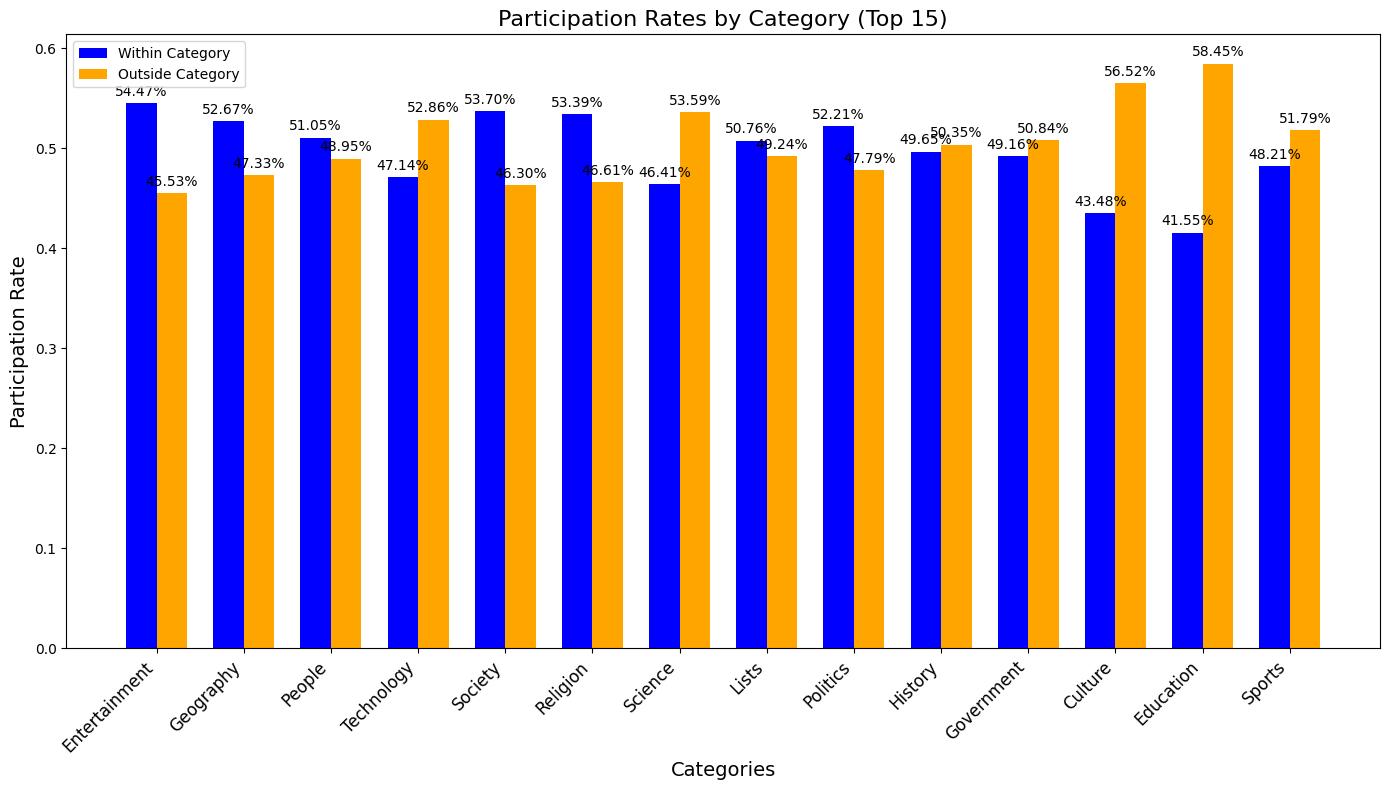

In [87]:
# Calculate participation rates for the top 15 categories
participation_data = []
for category in top_15_categories:
    # Count unique SRC users voting within and outside the category
    within_participation = df_vote[(df_vote['SRC_Category'] == category) & (df_vote['Category_Same'] == 1)]['SRC'].nunique()
    outside_participation = df_vote[(df_vote['SRC_Category'] == category) & (df_vote['Category_Same'] == 0)]['SRC'].nunique()
    
    # Total participation for the category
    total_participation = within_participation + outside_participation
    
    # Calculate rates
    within_rate = within_participation / total_participation if total_participation > 0 else 0
    outside_rate = outside_participation / total_participation if total_participation > 0 else 0
    participation_data.append((category, within_rate, outside_rate))

# Convert to structured format for plotting
categories, within_category_rates, outside_category_rates = zip(*participation_data)
print(participation_data)

# Plotting
x = np.arange(len(categories))  # the label locations
bar_width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - bar_width / 2, within_category_rates, bar_width, label='Within Category', color='blue')
rects2 = ax.bar(x + bar_width / 2, outside_category_rates, bar_width, label='Outside Category', color='orange')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Categories', fontsize=14)
ax.set_ylabel('Participation Rate', fontsize=14)
ax.set_title('Participation Rates by Category (Top 15)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=12)
ax.legend()

# Annotate bars with values
for rect in rects1:
    height = rect.get_height()
    ax.annotate(f'{height:.2%}',  # Convert to percentage format
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

for rect in rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2%}',  # Convert to percentage format
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

fig.tight_layout()
plt.show()


# Tolerance across same/different categories

,Category,Support Rate Within Same (%),Support Rate Within Different (%),Total Votes Within Same,Total Votes Within Different
0,Entertainment,79.754274,81.085990,18720,52855
1,Geography,82.465897,80.472238,9530,62045
2,People,81.700202,80.609725,8399,63176
3,Technology,82.775120,80.527687,6688,64887
4,Society,76.404287,81.092151,5412,66163
5,Religion,79.872204,80.789856,4069,67506
6,Science,80.437424,80.756004,4115,67460
7,Lists,83.194864,80.643289,2648,68927
8,Politics,78.837421,80.798005,2202,69373
9,History,77.146001,80.879897,2726,68849


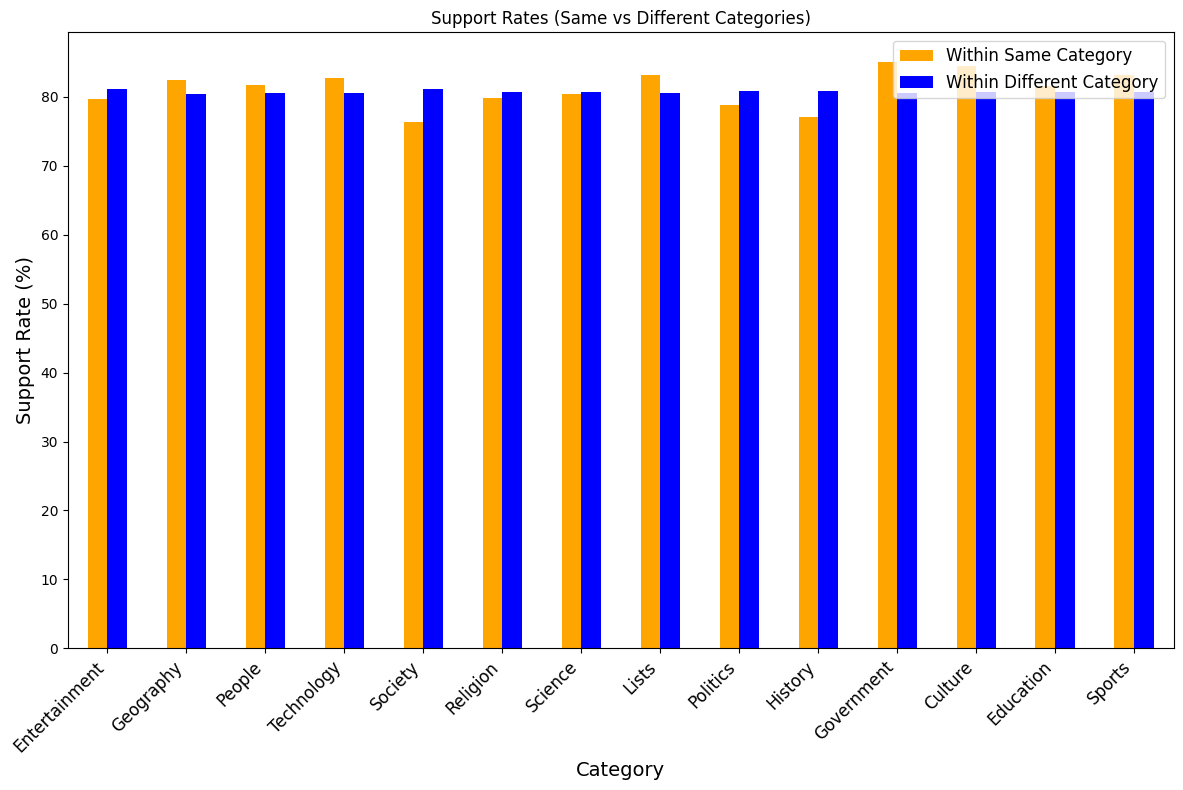

In [88]:
support_data = []

for category in top_15_categories:
    # Filter votes where SRC_Category matches the current category
    same_category_votes = df_vote[df_vote['SRC_Category'] == category]
    diff_category_votes = df_vote[df_vote['SRC_Category'] != category]

    # Calculate positive and negative votes
    same_pos = (same_category_votes['VOT'] == 1).sum()
    same_neg = (same_category_votes['VOT'] == -1).sum()
    diff_pos = (diff_category_votes['VOT'] == 1).sum()
    diff_neg = (diff_category_votes['VOT'] == -1).sum()
    
    # Calculate total positive + negative votes
    total_same = same_pos + same_neg
    total_diff = diff_pos + diff_neg
    
    # Calculate support rates
    same_support = same_pos / total_same if total_same > 0 else 0
    diff_support = diff_pos / total_diff if total_diff > 0 else 0
    
    # Append to analysis
    support_data.append({
        "Category": category,
        "Support Rate Within Same (%)": same_support * 100,
        "Support Rate Within Different (%)": diff_support * 100,
        "Total Votes Within Same": total_same,
        "Total Votes Within Different": total_diff
    })

# Convert to DataFrame for display
support_rates_df = pd.DataFrame(support_data)

# Display the analysis
display(support_rates_df)

# Visualize the support rates
ax = support_rates_df.plot(
    x="Category",
    y=["Support Rate Within Same (%)", "Support Rate Within Different (%)"],
    kind="bar",
    figsize=(12, 8),
    stacked=False,
    title="Support Rates (Same vs Different Categories)",
    ylabel="Support Rate (%)",
    color=["orange", "blue"]
)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Support Rate (%)", fontsize=14)
plt.legend(["Within Same Category", "Within Different Category"], loc="upper right", fontsize=12)
plt.tight_layout()
plt.show()


Analyzing the top 10 largest categories, we observe that users are more inclined to participate in votes related to topics that align with their own interests. This can be explained by the fact that individuals are likely to feel more knowledgeable or proficient in certain areas, making them more comfortable expressing their opinions or casting votes. This trend persists, even in the mid-sized categories ranked 10 to 20, suggesting a consistent preference for engaging with familiar topics across the user base.


## Code


Total voters analyzed for trends: 1074
Trend
No Significant Change    1021
More Chill                 30
More Strict                23
Name: count, dtype: int64


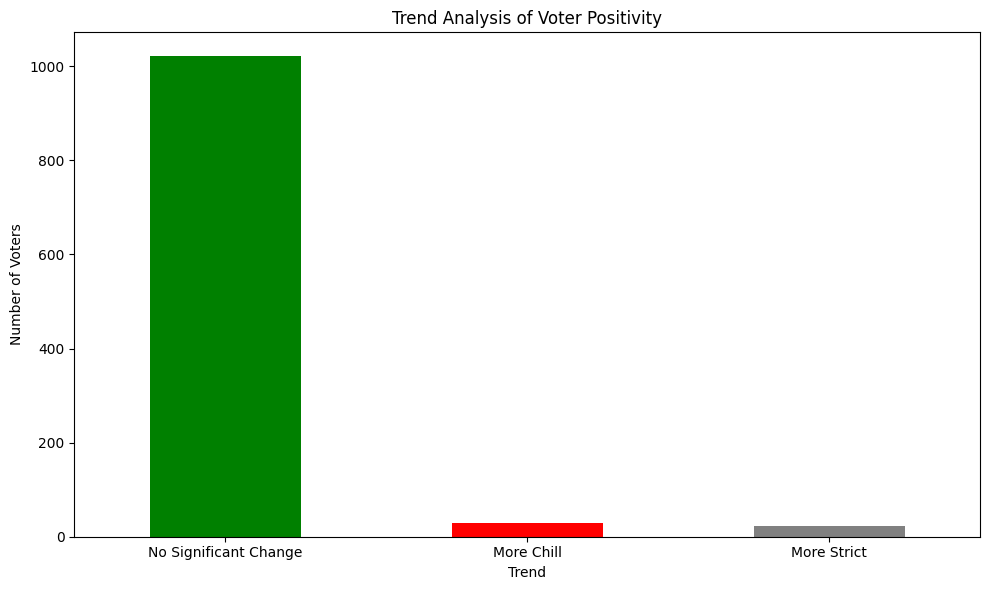

In [77]:
from scipy.stats import linregress

# Ensure 'DAT' is datetime and extract 'Year'
df_vote['Date'] = pd.to_datetime(df_vote['DAT'], errors='coerce', format='%H:%M, %d %B %Y')
df_vote['Year'] = df_vote['Date'].dt.year

# Drop rows with invalid dates
df_vote = df_vote.dropna(subset=['Year'])

# Calculate positivity ratios per voter per year
positivity_ratios = df_vote.groupby(['SRC', 'Year'])['VOT'].apply(
    lambda x: (x == 1).sum() / len(x) if len(x) > 0 else 0
).reset_index(name='Positivity_Ratio')

# Analyze trends using linear regression
trends = []
for voter in positivity_ratios['SRC'].unique():
    voter_data = positivity_ratios[positivity_ratios['SRC'] == voter]
    if len(voter_data) > 2:  # Ensure more than two years of data
        slope, _, _, p_value, _ = linregress(voter_data['Year'], voter_data['Positivity_Ratio'])
        trend = 'No Significant Change'
        if slope > 0 and p_value < 0.05:
            trend = 'More Chill'
        elif slope < 0 and p_value < 0.05:
            trend = 'More Strict'
        trends.append({
            'Voter': voter,
            'Trend': trend,
            'Slope': slope,
            'p_value': p_value
        })

# Convert trends to a DataFrame
trends_df = pd.DataFrame(trends)

# Display trends summary
print(f"Total voters analyzed for trends: {len(trends_df)}")
print(trends_df['Trend'].value_counts())

# Plot the trends
trend_counts = trends_df['Trend'].value_counts()
trend_counts.plot(kind='bar', color=['green', 'red', 'gray'], figsize=(10, 6))
plt.title('Trend Analysis of Voter Positivity')
plt.xlabel('Trend')
plt.ylabel('Number of Voters')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Table
 We tried to test the null hypothesis that tolerance rate is the same whether they are in the same/different category, p-values are on the last collumn.

# Code

# Votants Behavior 

We are studying behavior of votants, trying to see if they became more or less strict over the years, for that we look at voters that have voted in more than 1 year.

## Difference of behavior in the differents groups?

To test this we run the test with the null hypothesis is that the distribution of people being more strict/less strict and constant is the same among the groups than among the overall, the p-values are stored in the last collumn.

We see that there is not a huge difference in the distribution of behavior among groups

# Code

               Failures  Successes  Total  Success_Rate
SRC_Category                                           
Culture             179        972   1151      0.844483
Education           190        839   1029      0.815355
Entertainment      3790      14930  18720      0.797543
Geography          1671       7859   9530      0.824659
Government          247       1413   1660      0.851205
History             623       2103   2726      0.771460
Lists               445       2203   2648      0.831949
People             1537       6862   8399      0.817002
Politics            466       1736   2202      0.788374
Religion            819       3250   4069      0.798722
Science             805       3310   4115      0.804374
Society            1277       4135   5412      0.764043
Sports              109        540    649      0.832049
Technology         1152       5536   6688      0.827751
Chi-Square Statistic: 191.75644192530694
P-Value: 6.702372082800916e-34


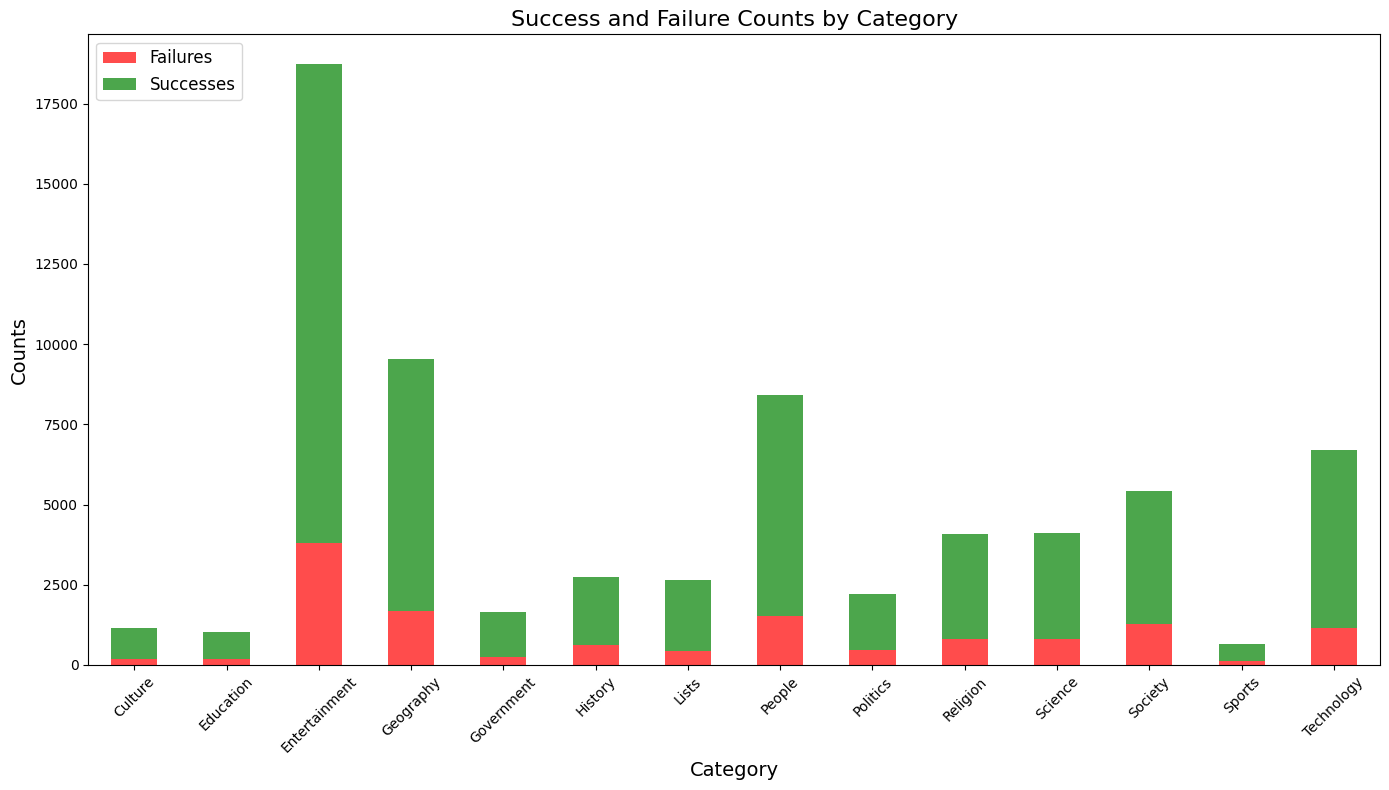

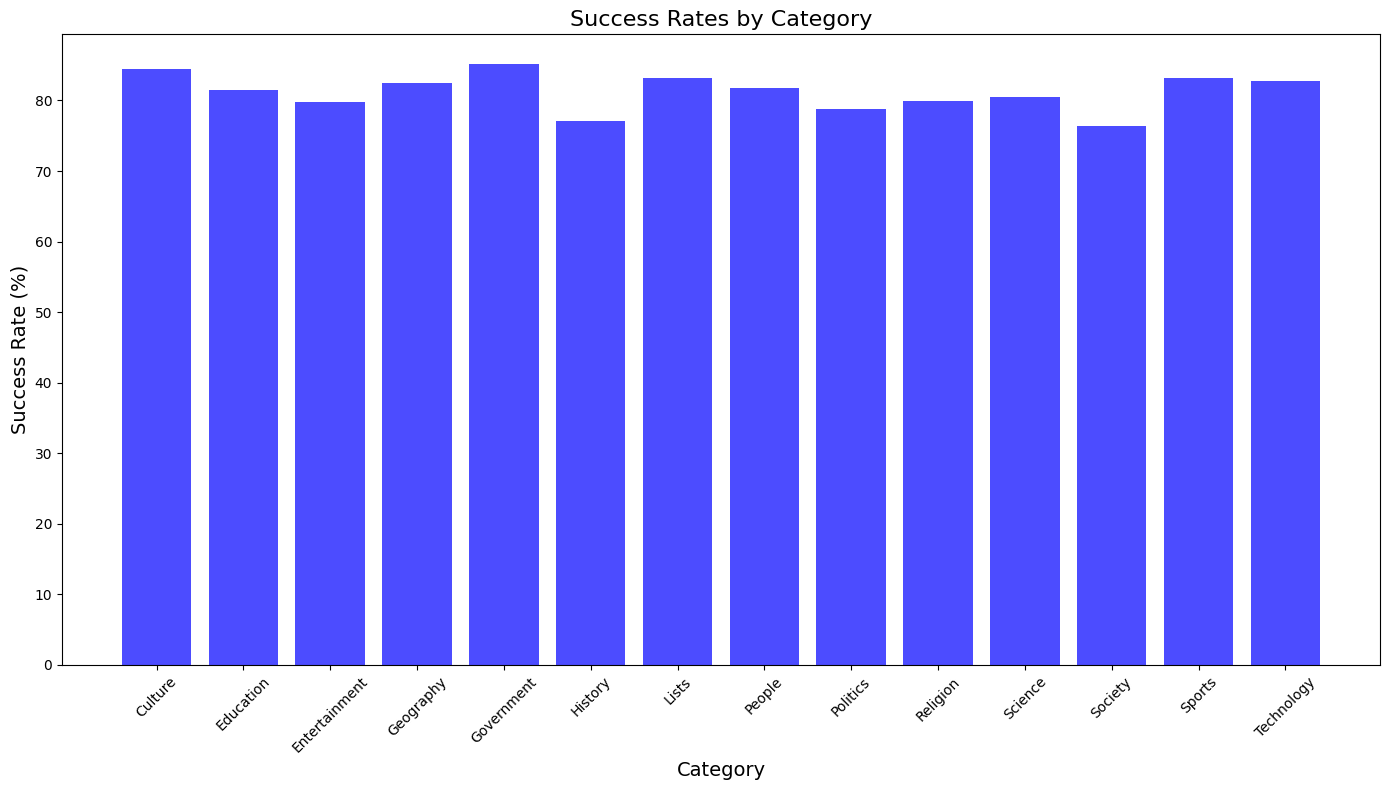

In [84]:
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

# Map categories from data (if required)
categories = pd.DataFrame(data)

# Calculate success and failure counts per category using df_vote
success_data = df_vote.groupby('SRC_Category')['VOT'].value_counts().unstack(fill_value=0)

# Keep only the columns for '1' (Successes) and '-1' (Failures)
if 1 not in success_data.columns or -1 not in success_data.columns:
    raise ValueError("df_vote must contain both positive (1) and negative (-1) votes.")

success_data = success_data[[-1, 1]]  # Failures (-1) and Successes (1)
success_data.columns = ['Failures', 'Successes']  # Rename columns for clarity
success_data['Total'] = success_data['Failures'] + success_data['Successes']
success_data['Success_Rate'] = success_data['Successes'] / success_data['Total']

# Display the success data
print(success_data)

# Perform a chi-square test for independence
contingency_table = success_data[['Failures', 'Successes']].T
chi2, p_value, _, _ = chi2_contingency(contingency_table)

# Display the results
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p_value}")

# Plot 1: Stacked bar chart for successes and failures
fig1, ax1 = plt.subplots(figsize=(14, 8))
success_data[['Failures', 'Successes']].plot(
    kind='bar',
    stacked=True,
    ax=ax1,
    color=['red', 'green'],
    alpha=0.7,
    label=['Failures', 'Successes']
)
ax1.set_title('Success and Failure Counts by Category', fontsize=16)
ax1.set_xlabel('Category', fontsize=14)
ax1.set_ylabel('Counts', fontsize=14)
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

# Plot 2: Histogram for success rates
fig2, ax2 = plt.subplots(figsize=(14, 8))
ax2.bar(success_data.index, success_data['Success_Rate'] * 100, color='blue', alpha=0.7)
ax2.set_title('Success Rates by Category', fontsize=16)
ax2.set_xlabel('Category', fontsize=14)
ax2.set_ylabel('Success Rate (%)', fontsize=14)
ax2.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Does your subject of interest have an influence on your chance of admission??

Chi-square test result: chi2 = 191.75644192530694, p-value = 6.702372082800916e-34
Statistically significant association between category and RfA success.


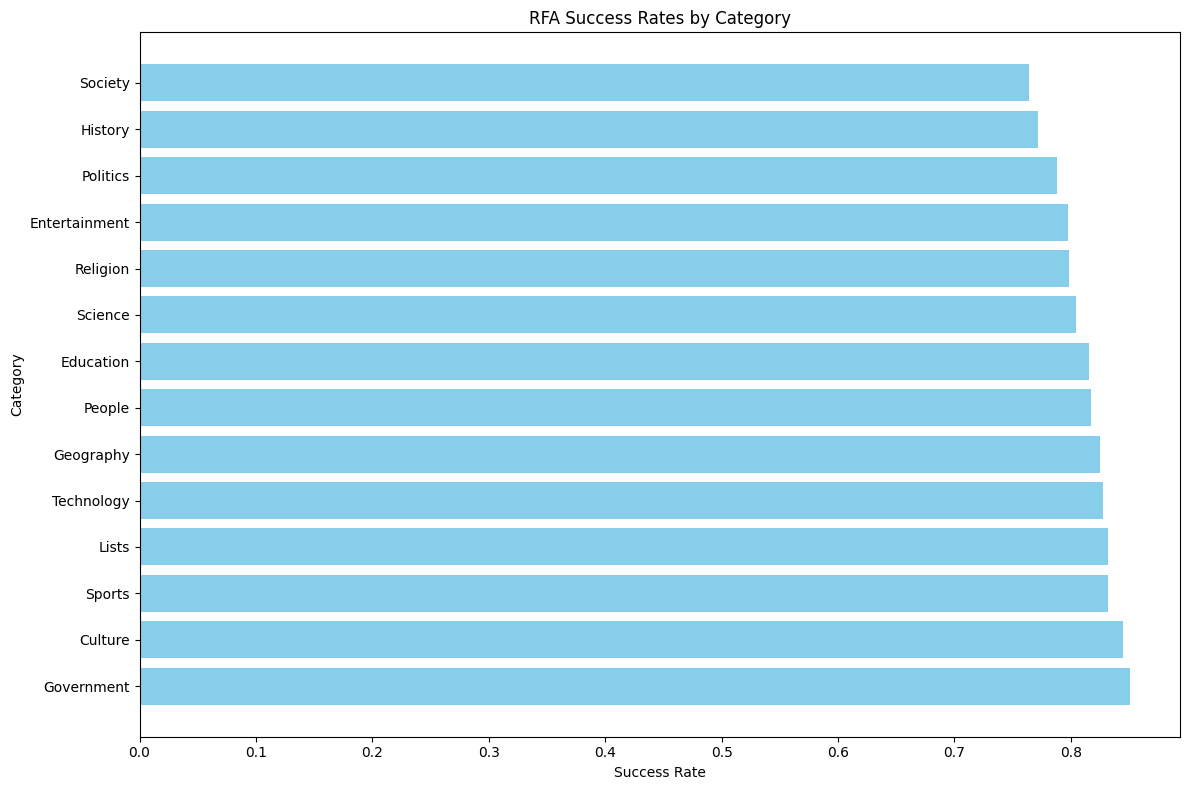

In [90]:

# Display chi-square test results
print(f"Chi-square test result: chi2 = {chi2}, p-value = {p_value}")
if p_value < 0.05:
    print("Statistically significant association between category and RfA success.")
else:
    print("No statistically significant association between category and RfA success.")

#
# Plotting success rates by category
success_data_sorted = success_data.sort_values(by='Success_Rate', ascending=False)
plt.figure(figsize=(12, 8))
plt.barh(success_data_sorted.index, success_data_sorted['Success_Rate'], color='skyblue')
plt.xlabel('Success Rate')
plt.ylabel('Category')
plt.title('RFA Success Rates by Category')
plt.tight_layout()
plt.show()


# Code

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import glob

# Function to load and concatenate CSV files from a specific directory
def load_data(file_pattern):
    all_files = glob.glob(file_pattern)
    df_list = []
    for filename in all_files:
        try:
            df = pd.read_csv(filename)
            if 'total_score' not in df.columns:
                print(f"Skipping file {filename} as it lacks the 'total_score' column.")
                continue
            df_list.append(df)
        except pd.errors.ParserError:
            print(f"Skipping file {filename} due to parsing error.")
    if not df_list:
        raise ValueError("No valid files to load. Check your file pattern or content.")
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

# Function to plot frequency by score range
def plot_score_frequency(data, score_column='total_score', range_size=None):
    # Ensure the score column is numeric, handling non-numeric values
    data[score_column] = pd.to_numeric(data[score_column], errors='coerce')
    data = data.dropna(subset=[score_column])  # Drop rows with NaN scores

    # Calculate dynamic range size if not provided
    min_score = data[score_column].min()
    max_score = data[score_column].max()
    if range_size is None:
        range_size = (max_score - min_score) // 10  # Default to 10 bins
        range_size = max(1, int(range_size))  # Ensure a minimum range size of 1

    # Create bins based on the specified range size
    bins = range(int(min_score), int(max_score) + range_size, range_size)
    data = data.copy()
    data['Score Range'] = pd.cut(data[score_column], bins=bins)
    frequency = data['Score Range'].value_counts().sort_index()

    # Plotting
    plt.figure(figsize=(12, 6))
    bars = plt.bar(frequency.index.astype(str), frequency.values, color='skyblue', edgecolor='black')

    # Add annotations on top of the bars
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()),
                 ha='center', va='bottom', fontsize=9)

    plt.xlabel('Score Range', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Frequency of Scores by {range_size}-point Ranges', fontsize=14)

    # Limit the number of x-axis ticks
    x_ticks = range(0, len(frequency), max(1, len(frequency) // 10))  # Show ~10 ticks
    plt.xticks(ticks=x_ticks, labels=[str(frequency.index[i]) for i in x_ticks], rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# Example usage
data = load_data('data/*.csv')

Skipping file data/user_categories_new_new_woohoo.csv due to parsing error.
Skipping file data/raw_outcomes.csv as it lacks the 'total_score' column.
Skipping file data/user_categories_clean.csv as it lacks the 'total_score' column.


In [91]:

import json
import seaborn as sns


# List of categories to include in the plot
categories_to_include = [
    "Academic disciplines", "Business", "Communication", "Concepts", "Culture", "Economy", "Education", "Energy",
    "Engineering", "Entertainment", "Entities", "Food and drink", "Geography", "Government", "Health", "History",
    "Human behavior", "Humanities", "Information", "Internet", "Knowledge", "Language", "Law", "Life", "Lists", "Mass media",
    "Mathematics", "Military", "Nature", "People", "Philosophy", "Politics", "Religion", "Science", "Society", "Sports",
    "Technology", "Time", "Universe", "Other"
]

# Function to load and concatenate CSV files from a specific directory
def load_data(file_pattern):
    all_files = glob.glob(file_pattern)
    df_list = []
    for filename in all_files:
        try:
            df = pd.read_csv(filename)
            df_list.append(df)
        except pd.errors.ParserError:
            print(f"Skipping file {filename} due to parsing error.")
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

# Function to load user categories from JSON file and expand them
def load_user_categories(json_file):
    with open(json_file, 'r') as file:
        user_categories = json.load(file)
    
    # Convert the categories dictionary to a DataFrame with one row per username-category pair
    categories_expanded = []
    for username, categories in user_categories.items():
        for category in categories:
            categories_expanded.append({'username': username, 'Category': category})
    categories_df = pd.DataFrame(categories_expanded)
    return categories_df

# Function to plot score distribution in groups of categories based on user count
def plot_score_distribution_grouped(data, categories_df, selected_categories, score_column='total_score', min_count=20):
    # Convert score_column to numeric, coercing errors to NaN
    data[score_column] = pd.to_numeric(data[score_column], errors='coerce')
    data = data.dropna(subset=[score_column])

    # Merge categories with the main data on 'username'
    data = data.merge(categories_df, on='username')

    # Filter data to include only the selected categories
    data = data[data['Category'].isin(selected_categories)]

    # Calculate the number of people per category
    category_counts = data['Category'].value_counts()
    
    # Filter out categories with fewer than the minimum required count
    valid_categories = category_counts[category_counts >= min_count].index
    data = data[data['Category'].isin(valid_categories)]

    # Group categories by count ranges (e.g., categories with similar user counts)
    # Define group ranges based on quantiles or fixed intervals for simplicity
    count_bins = np.linspace(category_counts[valid_categories].min(), category_counts[valid_categories].max(), num=5)
    category_groups = {f'Group {i+1}': [] for i in range(len(count_bins)-1)}
    
    for category, count in category_counts[valid_categories].items():
        for i in range(len(count_bins) - 1):
            if count_bins[i] <= count < count_bins[i + 1]:
                category_groups[f'Group {i+1}'].append(category)
                break

    # Plot score distributions for each group of categories
    for i, (group_name, group_categories) in enumerate(category_groups.items()):
        if group_categories:  # Only plot if the group has categories
            min_count_in_group = min(category_counts[group_categories])
            max_count_in_group = max(category_counts[group_categories])
            plt.figure(figsize=(14, 8))
            sns.boxplot(x=score_column, y='Category', data=data[data['Category'].isin(group_categories)], orient='h')
            plt.xlabel('Score')
            plt.ylabel('Category')
            plt.title(f'{group_name} - Score Distribution for Categories with {min_count_in_group}-{max_count_in_group} People')
            plt.tight_layout()
            plt.show()

# Example usage
data = load_data('data/*.csv')  # Load CSV data
categories_df = load_user_categories('data/user_categories.json')  # Load and expand user categories



Skipping file data/user_categories_new_new_woohoo.csv due to parsing error.


# Admin scores distribution

We first plot the distribution of adminscores over the data set.

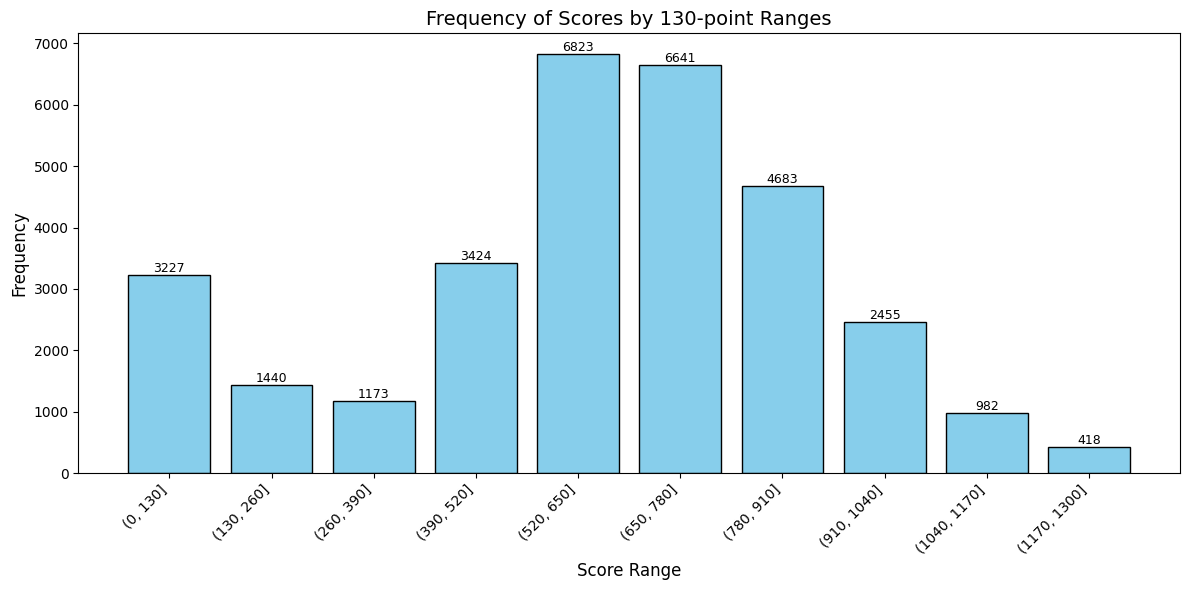

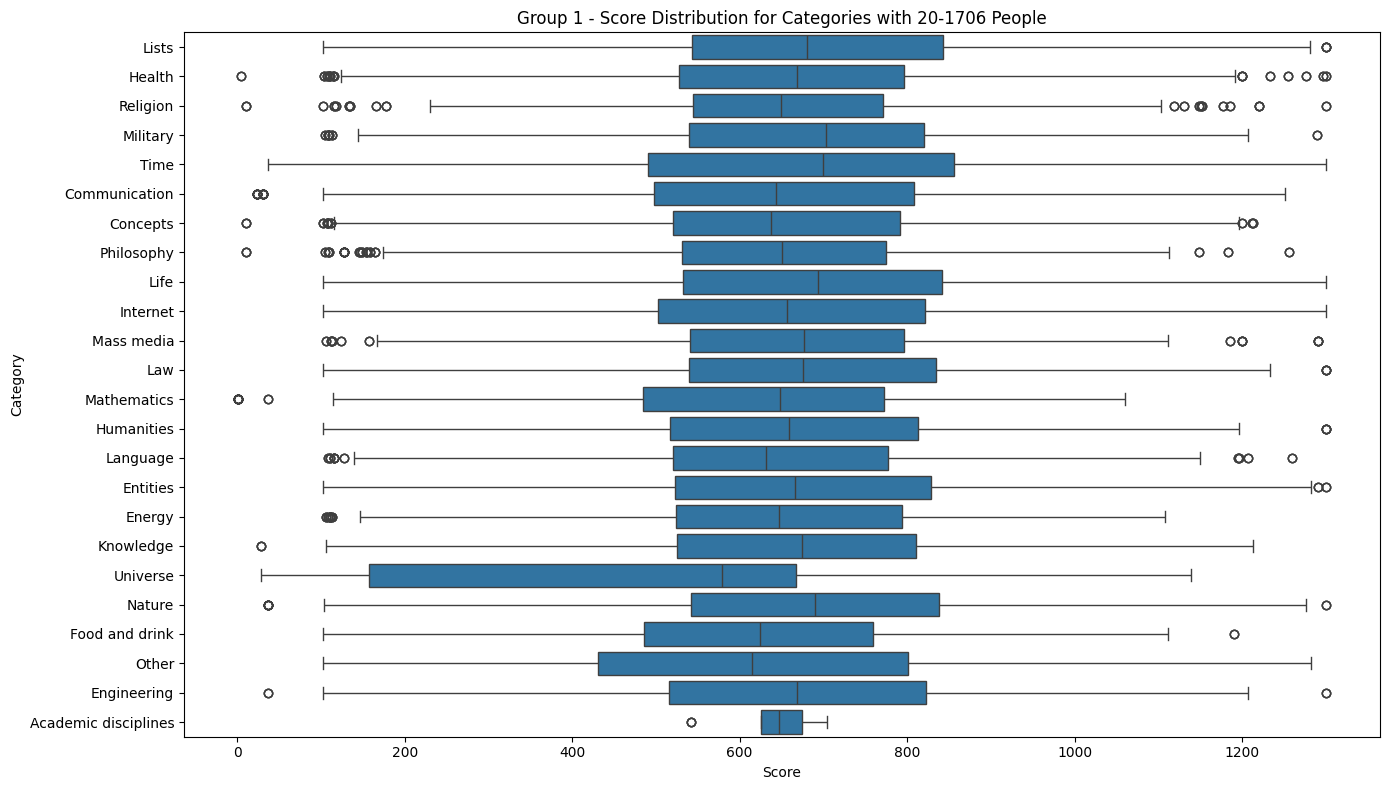

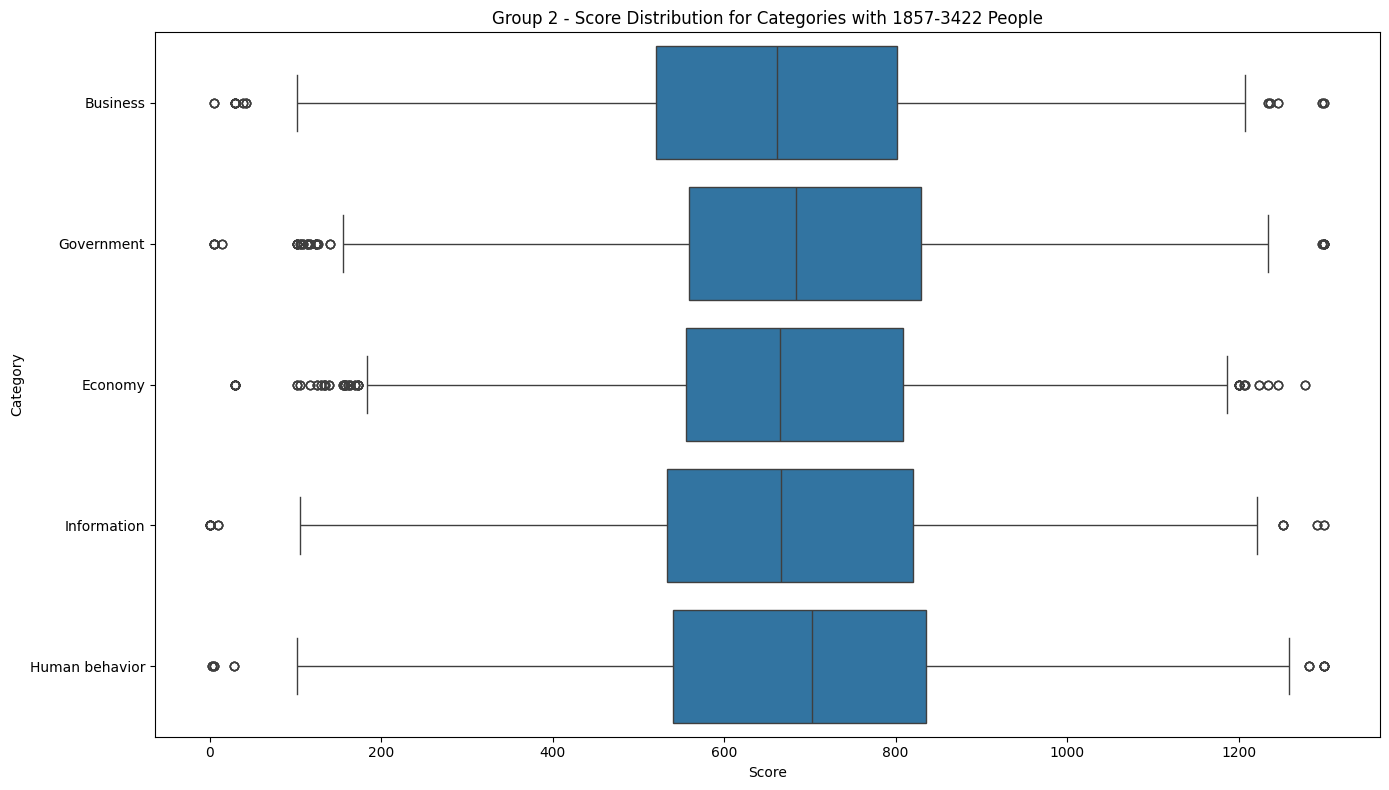

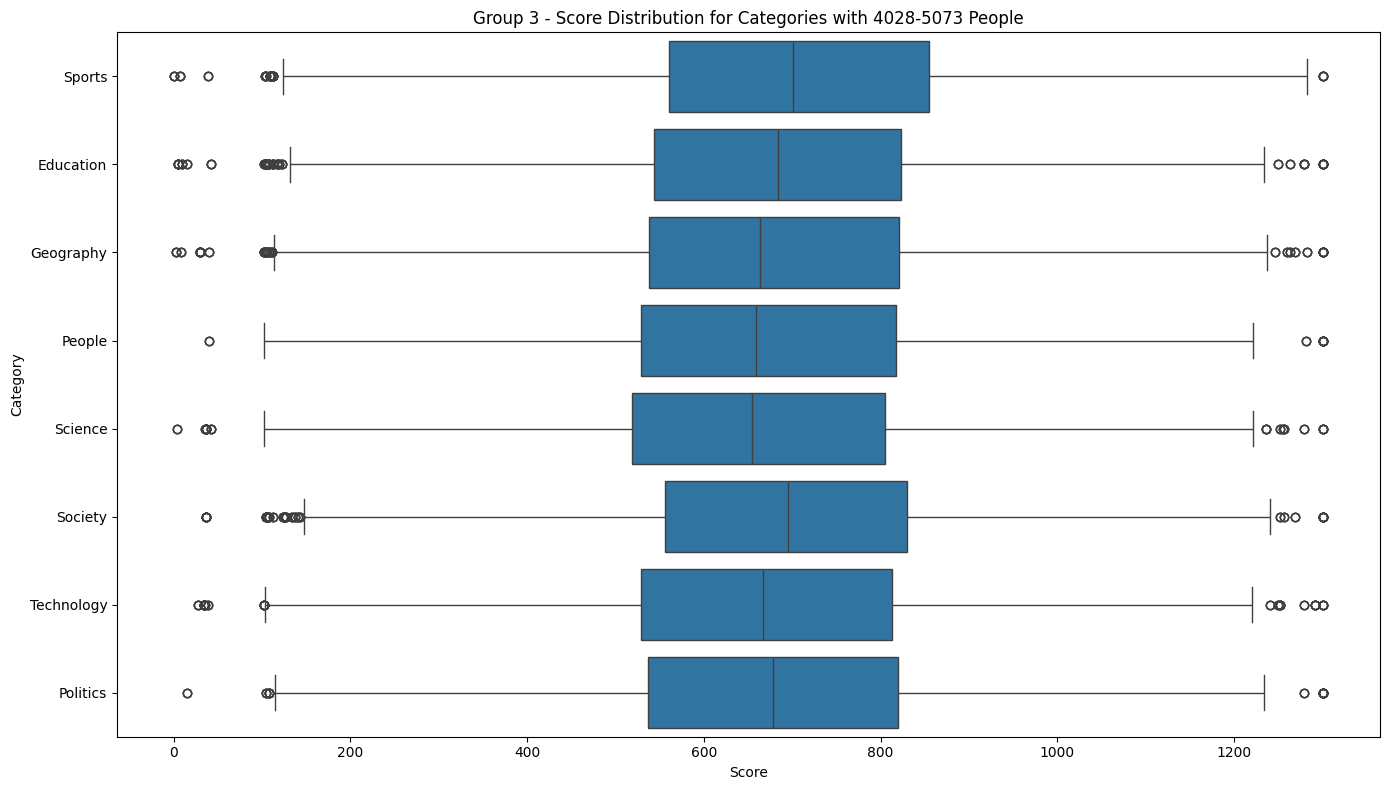

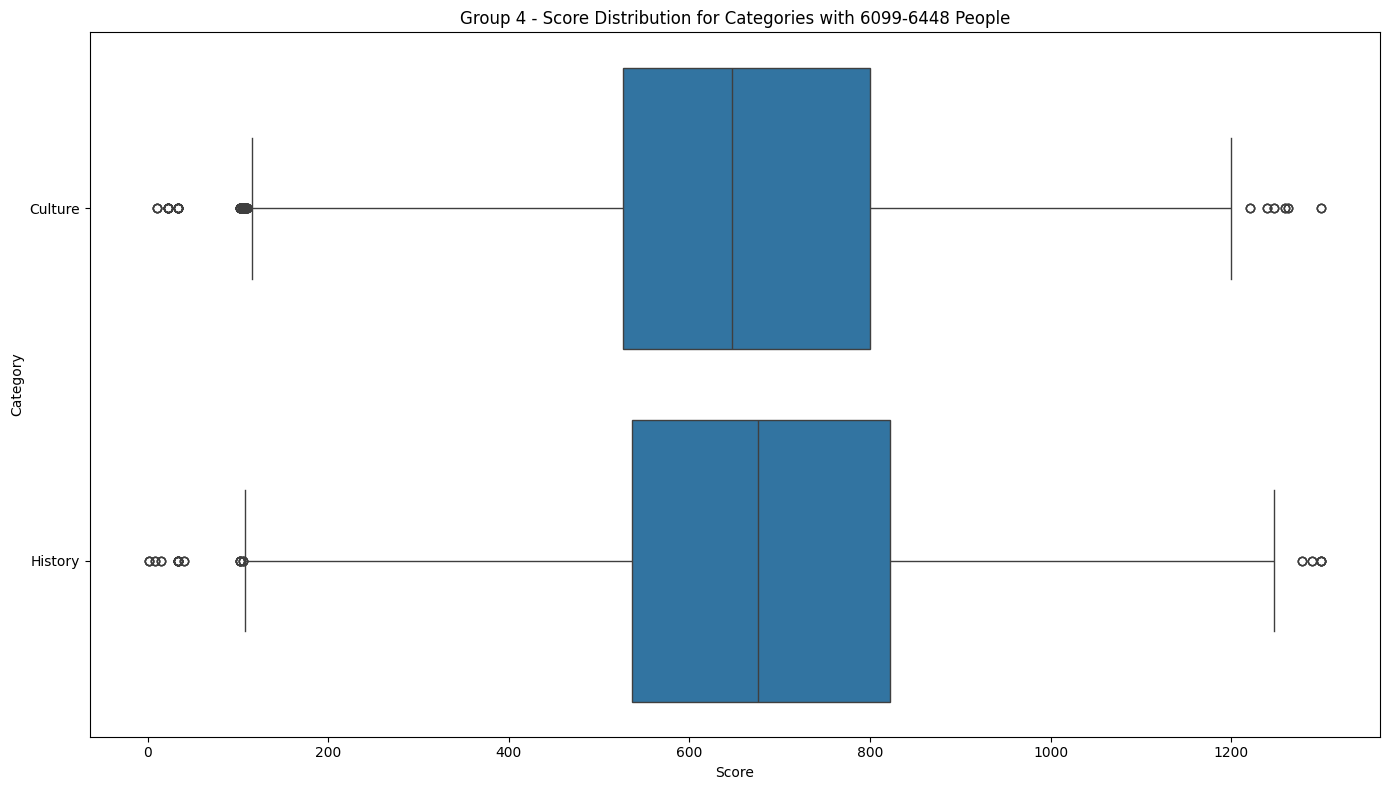

In [ ]:
import numpy as np 
plot_score_frequency(data, score_column='total_score')

# Plot score distribution grouped by user count similarity, with categories having at least 20 people
plot_score_distribution_grouped(data, categories_df, categories_to_include)


Let us notice that the boxplot for categories like, time, universe and others are not really significant since there are not enough users in these categories to fair results

## Approbation rates vs outcome

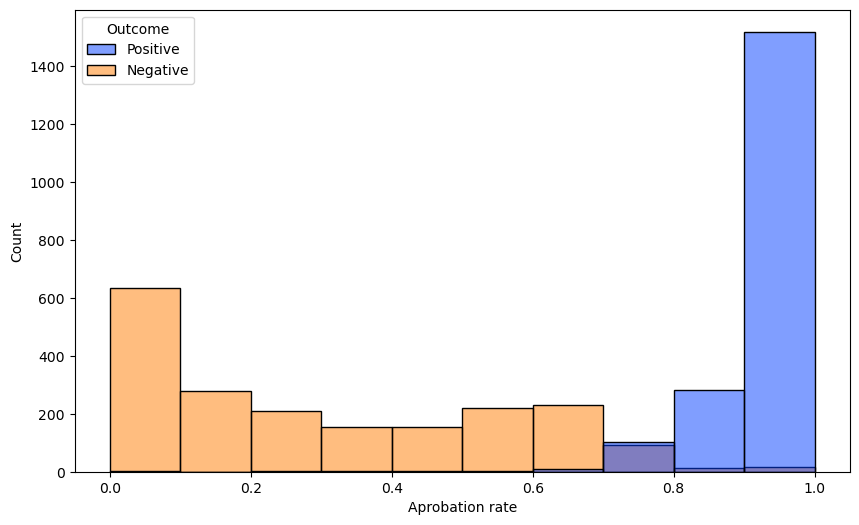

In [ ]:
from src.scripts.GalPlots import *
plot_outcomes_approbation_rates("data/wiki-RfA.txt")

## Succes rate over years

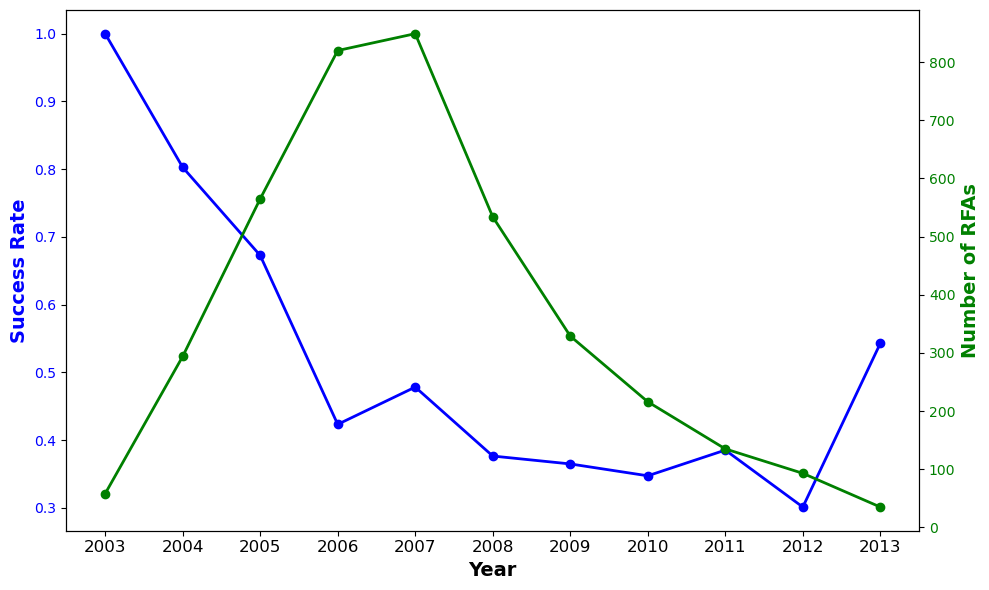

In [ ]:
from src.scripts.GalPlots import *
plot_success_rates("data/wiki-RfA.txt")

## Admin score hist

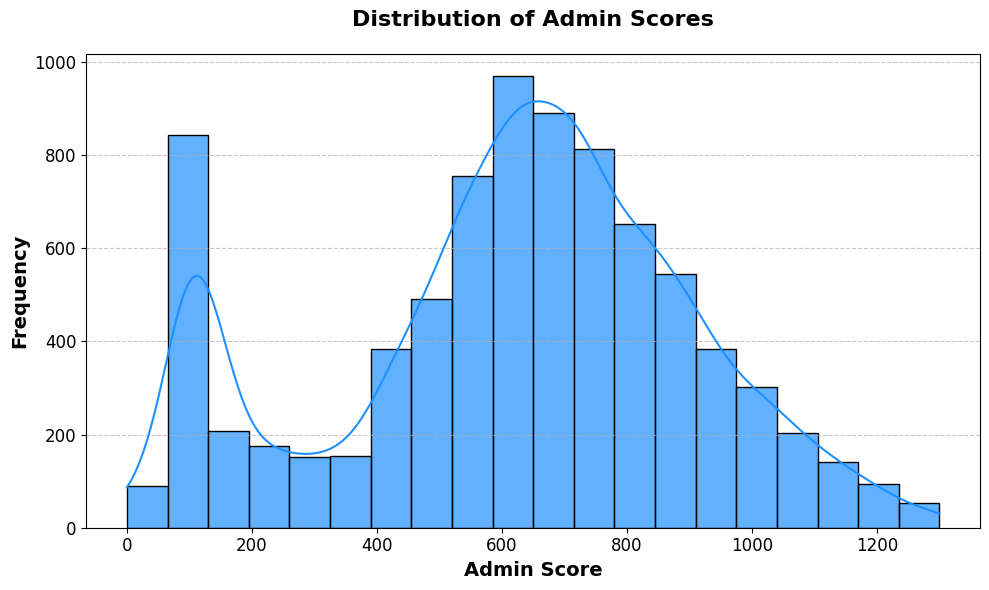

In [ ]:
from src.scripts.GalPlots import *
plot_admin_scores_hist("data/scores.csv")